In [17]:
# Modifying the provided 'edited-model.py' to incorporate suggested improvements

# Modified script content with additional tuning, early stopping, and class distribution checks.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorboard import notebook

In [18]:
# Load the data
df = pd.read_csv('C:/Users/honey/Documents/placment work/Electronical-AI-Device-Recogniser/khanya/data managment/datasets/acs-f2-dataset.csv')

In [19]:
# Data Preprocessing
df = df.drop('time', axis=1)

# Convert categorical labels to numeric
le = LabelEncoder()
df['equipment'] = le.fit_transform(df['equipment'])
class_names = le.classes_

# Split features and labels
X = df.drop('equipment', axis=1)
y = df['equipment']

# Analyze class distribution before SMOTE
print("Class distribution before SMOTE:")
print(y.value_counts())

# Normalize the features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Handle class imbalance using SMOTE
# sm = SMOTE(random_state=42)
# X_resampled, y_resampled = sm.fit_resample(X_scaled, y)

Class distribution before SMOTE:
equipment
3     10776
2     10772
12    10763
13    10762
14    10751
1     10747
11    10742
0     10737
4     10735
6     10734
5     10733
10    10727
8     10716
9     10711
7     10702
Name: count, dtype: int64


In [ ]:

# Drop the 'time' column as it's not relevant for prediction
df = df.drop('time', axis=1)

# Convert categorical labels to numeric
le = LabelEncoder()
df['equipment'] = le.fit_transform(df['equipment'])

# Split features and labels
X = df.drop('equipment', axis=1)
y = df['equipment']

In [20]:
# Analyze class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

# One-hot encode the target labels
num_classes = len(np.unique(y))
y_resampled_onehot = to_categorical(y_resampled, num_classes=num_classes)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled_onehot, test_size=0.2, random_state=42)

Class distribution after SMOTE:
equipment
0     10776
1     10776
2     10776
3     10776
4     10776
5     10776
6     10776
7     10776
8     10776
9     10776
10    10776
11    10776
12    10776
13    10776
14    10776
Name: count, dtype: int64


In [21]:
from tensorflow.keras.layers import Input, Concatenate, Multiply
from tensorflow.keras import backend as K

# Define the model architecture with weighted input for 'freq' column and dropout
input_layer = Input(shape=(X_train.shape[1],))
freq_weight = K.constant([[2.0]])  # Convert the weight to a tensor with the same shape as freq_input

# Split the input into 'freq' and other features
freq_input = input_layer[:, 0:1]
other_features = input_layer[:, 1:]

# Apply the weight to the 'freq' column
weighted_freq = Multiply()([freq_input, freq_weight])

# Concatenate the weighted 'freq' column back with the other features
weighted_input = Concatenate()([weighted_freq, other_features])

# Define the rest of the model
x = Dense(256, activation='relu')(weighted_input)
x = Dropout(0.3)(x)  # Increased dropout for stronger regularization
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model with a lower learning rate for better generalization
model.compile(optimizer=Adam(learning_rate=0.0005), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    epochs=100, 
                    batch_size=32, 
                    callbacks=[early_stopping])


Epoch 1/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.3274 - loss: 1.9841 - val_accuracy: 0.4943 - val_loss: 1.4514
Epoch 2/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.4734 - loss: 1.4857 - val_accuracy: 0.5629 - val_loss: 1.2379
Epoch 3/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5300 - loss: 1.3161 - val_accuracy: 0.6106 - val_loss: 1.1195
Epoch 4/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5651 - loss: 1.2181 - val_accuracy: 0.6369 - val_loss: 1.0389
Epoch 5/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5902 - loss: 1.1480 - val_accuracy: 0.6565 - val_loss: 0.9860
Epoch 6/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6107 - loss: 1.0908 - val_accuracy: 0.6743 - val_loss: 0.9327
Epoch 7/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6231 - loss: 1.0518 - val_accuracy: 0.6807 - val_loss: 0.9062
Epoch 8/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6330 - loss: 1

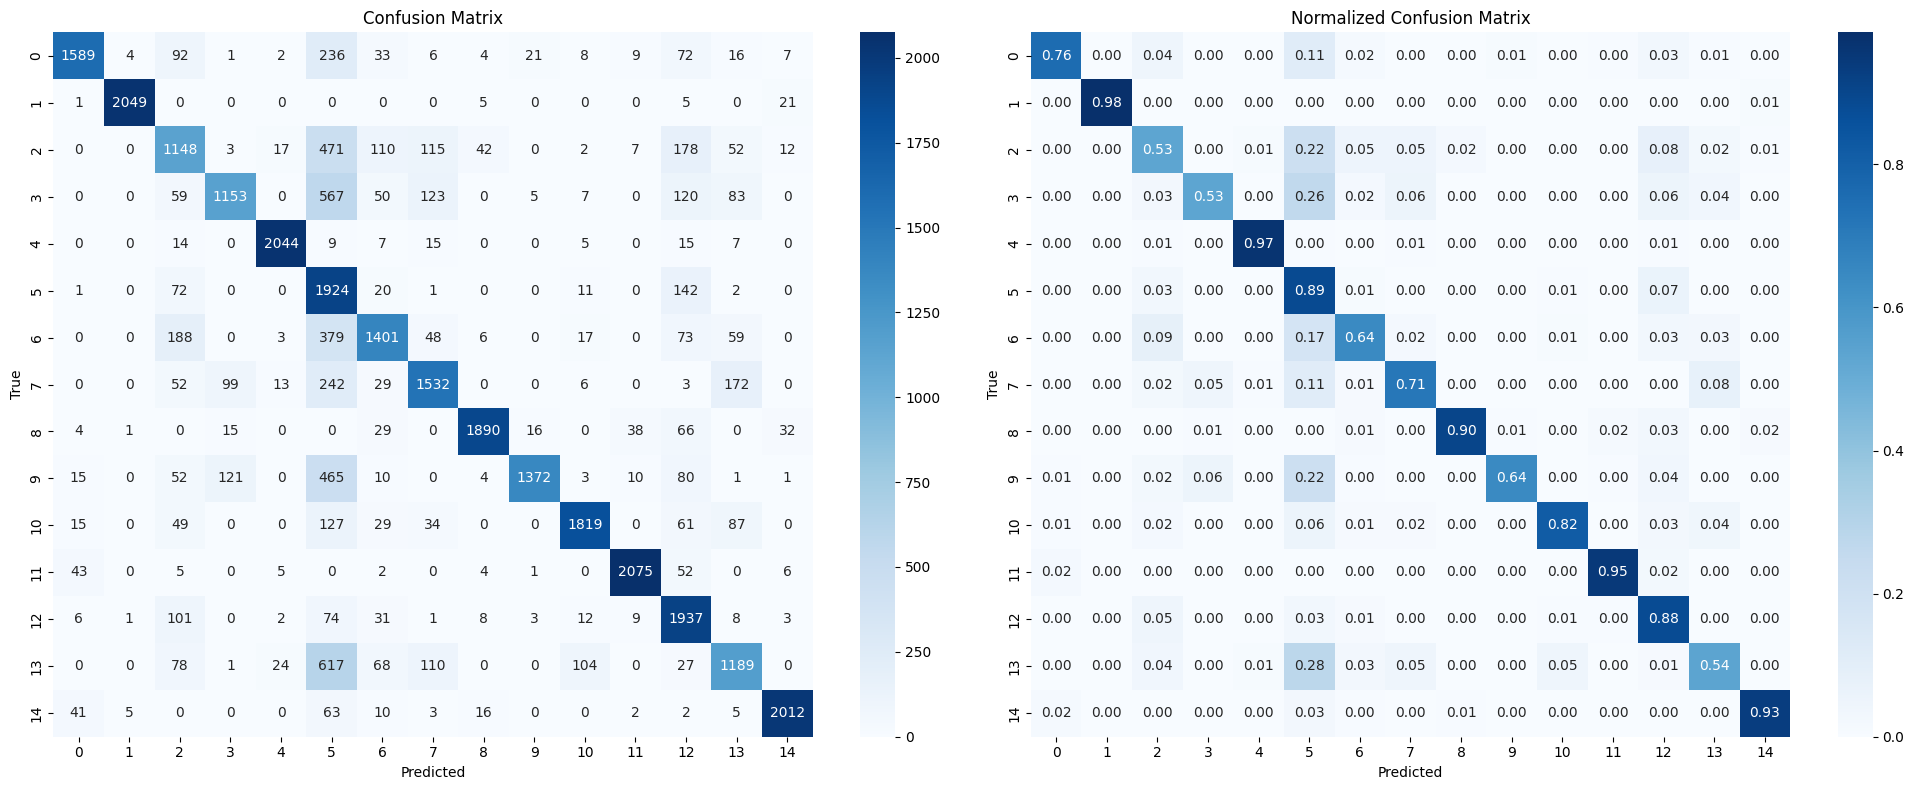

In [25]:
# Plot confusion matrix
cm = confusion_matrix(y_true_classes[:len(y_pred_classes)], y_pred_classes)
plt.figure(figsize=(20, 8))

# Plot the regular confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plot the normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.subplot(1, 2, 2)
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues')
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()


In [23]:
# Save the trained model and the scaler for future use
model.save('new-model1.0.3.keras')
joblib.dump(scaler, 'new-scaler1.0.3.pkl')

['new-scaler1.0.3.pkl']

In [24]:
  # Return the new path so the user can download it